<a href="https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/tensorflow/text_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow_datasets as tfds

import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
#print("GPU Available:", tf.test.is_gpu_available())
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.3.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). The dataset comes with an inbuilt subword tokenizer.


In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteIJJG1K/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteIJJG1K/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteIJJG1K/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


As this is a subwords tokenizer, it can be passed any string and the tokenizer will tokenize it.

In [5]:
tokenizer = info.features['text'].encoder

In [6]:
print ('Vocabulary size: {}'.format(tokenizer.vocab_size))

Vocabulary size: 8185


In [7]:
sample_string = 'TensorFlow is cool.'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [6307, 2327, 4043, 4265, 9, 2724, 7975]
The original string: TensorFlow is cool.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [8]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
4265 ----> ow 
9 ----> is 
2724 ----> cool
7975 ----> .


In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [10]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Compile the Keras model to configure the training process:

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train the model

In [13]:
#history = model.fit(train_dataset, epochs=10,
#                    validation_data=test_dataset)
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset)

Epoch 1/2
391/391 [==============================] - 59s 151ms/step - loss: 0.5690 - accuracy: 0.6977 - val_loss: 0.5027 - val_accuracy: 0.7594
Epoch 2/2
391/391 [==============================] - 59s 150ms/step - loss: 0.4960 - accuracy: 0.7701 - val_loss: 0.6384 - val_accuracy: 0.6210


In [14]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 18s 46ms/step - loss: 0.6384 - accuracy: 0.6210
Test Loss: 0.6383674740791321
Test Accuracy: 0.6209999918937683


The above model does not mask the padding applied to the sequences. This can lead to skewness if we train on padded sequences and test on un-padded sequences. Ideally the model would learn to ignore the padding, but as you can see below it does have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [15]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [16]:
def sample_predict(sentence, pad):
  tokenized_sample_pred_text = tokenizer.encode(sample_pred_text)

  if pad:
    tokenized_sample_pred_text = pad_to_size(tokenized_sample_pred_text, 64)

  predictions = model.predict(tf.expand_dims(tokenized_sample_pred_text, 0))

  return (predictions)

In [17]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.679724]]


In [18]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.6818894]]


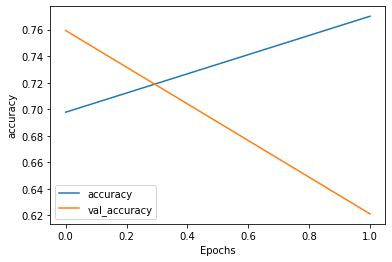

In [19]:
plot_graphs(history, 'accuracy')

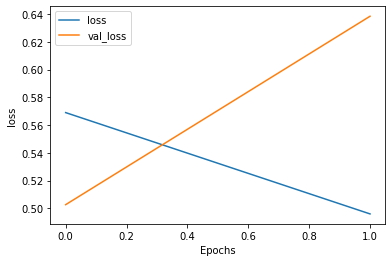

In [20]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
#history = model.fit(train_dataset, epochs=10,
#                    validation_data=test_dataset)
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset)

Epoch 1/2
391/391 [==============================] - 104s 265ms/step - loss: 0.5941 - accuracy: 0.6877 - val_loss: 0.5613 - val_accuracy: 0.7086
Epoch 2/2
391/391 [==============================] - 102s 262ms/step - loss: 0.4556 - accuracy: 0.7988 - val_loss: 0.4436 - val_accuracy: 0.8002


In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 33s 85ms/step - loss: 0.4436 - accuracy: 0.8002
Test Loss: 0.4436035454273224
Test Accuracy: 0.8002399802207947


In [25]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.11004001]]


In [26]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.16868636]]


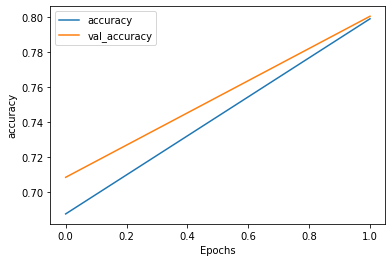

In [27]:
plot_graphs(history, 'accuracy')

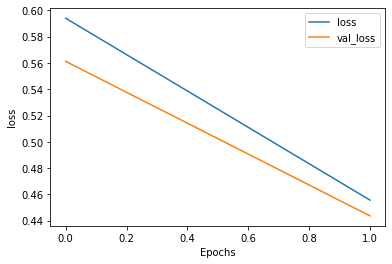

In [28]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).